In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import math
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' , skiprows = 1, header = None)
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 
              'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [3]:
print('Train size:: {}'.format(train_set.shape))
print('Test size:: {}'.format(test_set.shape))

Train size:: (32561, 15)
Test size:: (16281, 15)


In [4]:
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [6]:
train_set.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
train_set.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [8]:
train_set.describe(include=["object"]).T

,count,unique,top,freq
workclass,32561,9,Private,22696
education,32561,16,HS-grad,10501
marital_status,32561,7,Married-civ-spouse,14976
occupation,32561,15,Prof-specialty,4140
relationship,32561,6,Husband,13193
race,32561,5,White,27816
sex,32561,2,Male,21790
native_country,32561,42,United-States,29170
wage_class,32561,2,<=50K,24720


In [9]:
test_set.describe(include=["object"]).T

,count,unique,top,freq
workclass,16281,9,Private,11210
education,16281,16,HS-grad,5283
marital_status,16281,7,Married-civ-spouse,7403
occupation,16281,15,Prof-specialty,2032
relationship,16281,6,Husband,6523
race,16281,5,White,13946
sex,16281,2,Male,10860
native_country,16281,41,United-States,14662
wage_class,16281,2,<=50K.,12435


In [10]:
# Check if duplicate data exist
check_dup = train_set.duplicated().any() 
print("Are there any duplicated values in data? ",check_dup)

if check_dup:
    train_set = train_set.drop_duplicates()
else:
    print("There are not duplicated values in data.")

check_dup_test = test_set.duplicated().any() 
print("Are there any duplicated values in data? ",check_dup)

if check_dup:
    test_set = test_set.drop_duplicates()
else:
    print("There are not duplicated values in data.")

Are there any duplicated values in data?  True
Are there any duplicated values in data?  True


In [11]:
object_columns=train_set.select_dtypes(include=["object"]).columns
for i in range(len(object_columns)):
    print("----- {}-----".format(object_columns[i]))
    print(train_set[object_columns[i]].value_counts())

----- workclass-----
 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
----- education-----
 HS-grad         10494
 Some-college     7282
 Bachelors        5353
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: education, dtype: int64
----- marital_status-----
 Married-civ-spouse       14970
 Never-married            10667
 Divorced                  4441
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital_status, dtype: int64
--

In [12]:
train_set.replace([' ?'], np.nan, inplace=True)
test_set.replace([' ?'], np.nan, inplace=True)

In [13]:
train_set.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     582
wage_class           0
dtype: int64

In [14]:
test_set.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        966
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    274
wage_class          0
dtype: int64

In [15]:
object_columns=train_set.select_dtypes(include=["object"]).columns
for i in range(len(object_columns)):
    print("----- {}-----".format(object_columns[i]))
    print(train_set[object_columns[i]].value_counts())

----- workclass-----
 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
----- education-----
 HS-grad         10494
 Some-college     7282
 Bachelors        5353
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: education, dtype: int64
----- marital_status-----
 Married-civ-spouse       14970
 Never-married            10667
 Divorced                  4441
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital_status, dtype: int64
----- occupation-----
 Prof-s

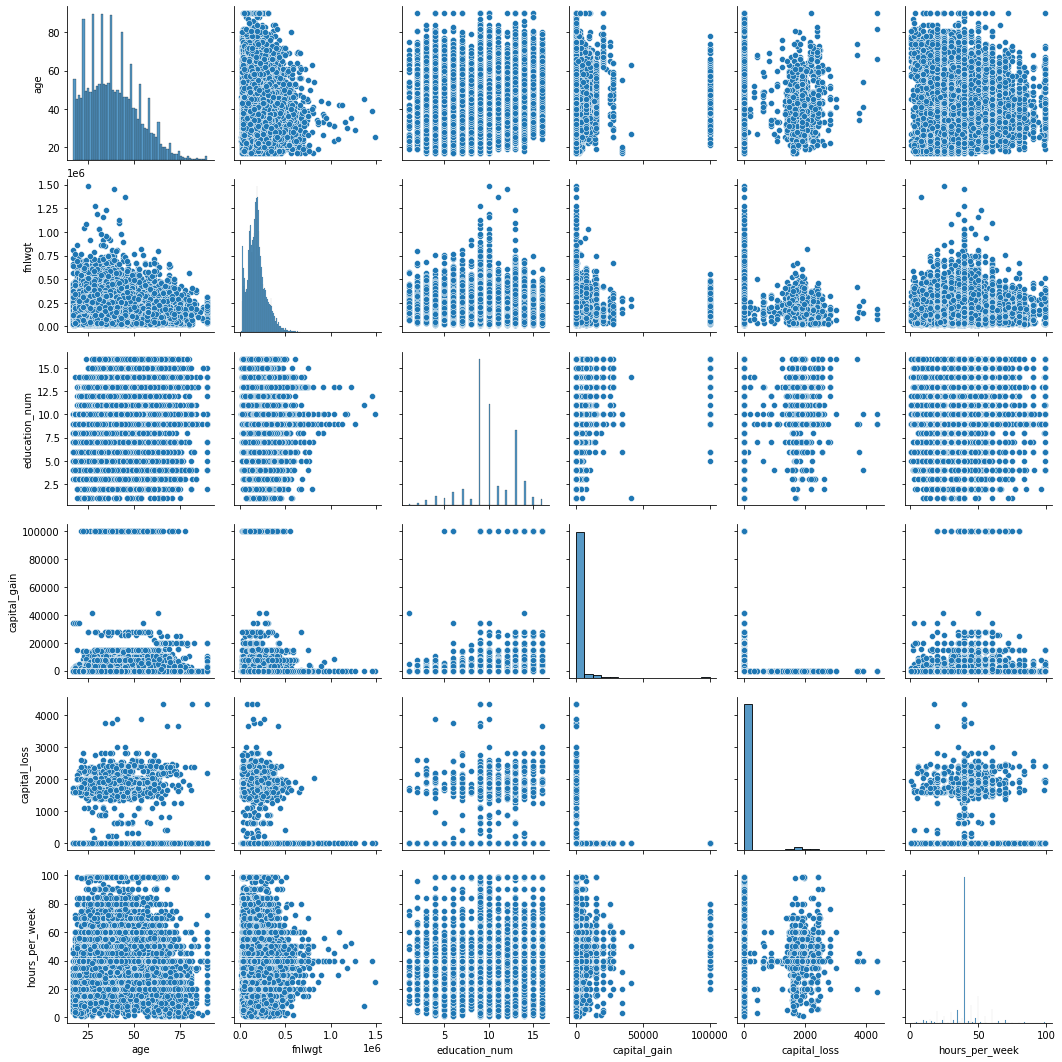

In [16]:
sns.pairplot(train_set)

In [17]:
train_set.education.value_counts()

 HS-grad         10494
 Some-college     7282
 Bachelors        5353
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: education, dtype: int64

In [18]:
train_set.education_num.value_counts()

9     10494
10     7282
13     5353
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: education_num, dtype: int64

In [19]:
## As education and education_num are same, we are dropping education column
train_set.drop(columns=['education'], inplace=True)
test_set.drop(columns=['education'], inplace=True)

In [20]:
train_set["education_num"]=train_set["education_num"].astype(CategoricalDtype(ordered=True)) #ordinal data.
test_set["education_num"]=test_set["education_num"].astype(CategoricalDtype(ordered=True))
train_set["education_num"].head()

0    13
1    13
2     9
3     7
4    13
Name: education_num, dtype: category
Categories (16, int64): [1 < 2 < 3 < 4 ... 13 < 14 < 15 < 16]

In [21]:
train_set.education_num.value_counts()

9     10494
10     7282
13     5353
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: education_num, dtype: int64

C:\Users\Urvi\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='wage_class', ylabel='count'>

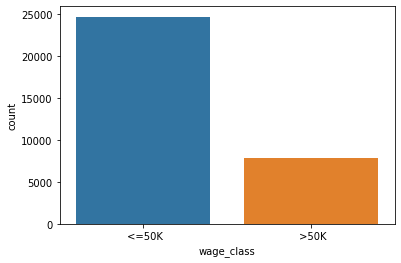

In [22]:
sns.countplot(train_set.wage_class)

In [23]:
train_set.skew()

age                0.557663
fnlwgt             1.447703
capital_gain      11.949403
capital_loss       4.592702
hours_per_week     0.228759
dtype: float64

C:\Users\Urvi\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Urvi\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Urvi\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

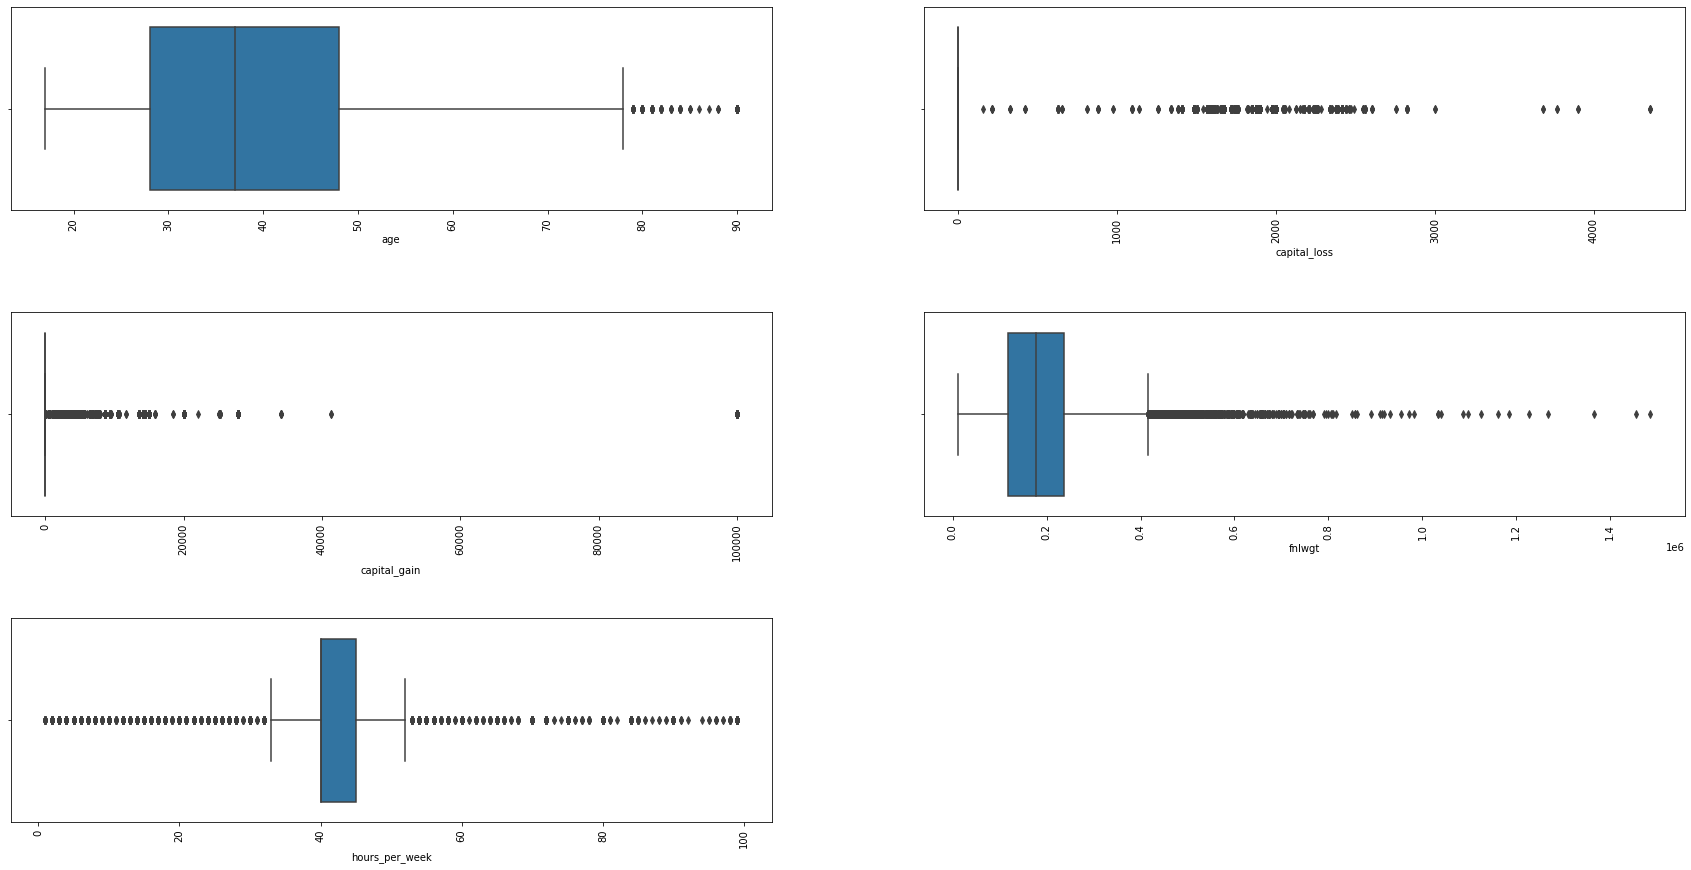

In [24]:
plt.figure(figsize=(30,15))

plt.subplot(321)
sns.boxplot(train_set["age"])
plt.xticks(rotation=90)

plt.subplot(322)
sns.boxplot(train_set["capital_loss"])
plt.xticks(rotation=90)

plt.subplot(323)
sns.boxplot(train_set["capital_gain"])
plt.xticks(rotation=90)

plt.subplot(324)
sns.boxplot(train_set["fnlwgt"])
plt.xticks(rotation=90)

plt.subplot(325)
sns.boxplot(train_set["hours_per_week"])
plt.xticks(rotation=90)

plt.subplots_adjust(hspace=0.5)
plt.show()

In [25]:
numeric_columns=list(train_set.select_dtypes(include=["int64"]).columns) #numeric columns
numeric_columns

['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week']

<AxesSubplot:>

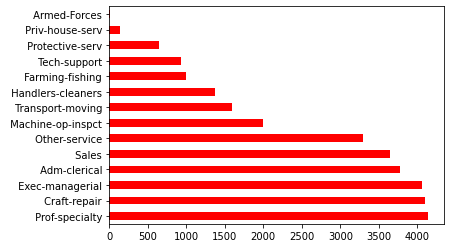

In [26]:
train_set["occupation"].value_counts().plot.barh(color="red")

<AxesSubplot:>

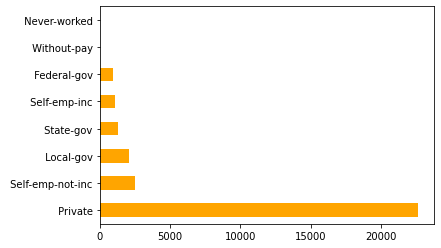

In [27]:
train_set["workclass"].value_counts().plot.barh(color="orange")

In [28]:
train_set.native_country.value_counts()

 United-States                 29153
 Mexico                          639
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Japan                            62
 Guatemala                        62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 Greece                           29
 

In [29]:
for i in ["occupation","workclass","native_country"]:
    train_set[i].fillna(train_set[i].mode()[0],inplace=True)
    test_set[i].fillna(test_set[i].mode()[0],inplace=True)

In [30]:
train_set.isnull().sum()

age               0
workclass         0
fnlwgt            0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [31]:
test_set.isnull().sum()

age               0
workclass         0
fnlwgt            0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [32]:
#Assigning the numeric values to the string type variables
number = LabelEncoder()
train_set['workclass'] = number.fit_transform(train_set['workclass'])
train_set['marital_status'] = number.fit_transform(train_set['marital_status'])
train_set['occupation'] = number.fit_transform(train_set['occupation'])
train_set['relationship'] = number.fit_transform(train_set['relationship'])
train_set['race'] = number.fit_transform(train_set['race'])
train_set['sex'] = number.fit_transform(train_set['sex'])
train_set['native_country'] = number.fit_transform(train_set['native_country'])
train_set['wage_class'] = number.fit_transform(train_set['wage_class'])

test_set['workclass'] = number.fit_transform(test_set['workclass'])
test_set['marital_status'] = number.fit_transform(test_set['marital_status'])
test_set['occupation'] = number.fit_transform(test_set['occupation'])
test_set['relationship'] = number.fit_transform(test_set['relationship'])
test_set['race'] = number.fit_transform(test_set['race'])
test_set['sex'] = number.fit_transform(test_set['sex'])
test_set['native_country'] = number.fit_transform(test_set['native_country'])
test_set['wage_class'] = number.fit_transform(test_set['wage_class'])

In [33]:
train_set['age_bin'] = pd.cut(train_set['age'], 20)
test_set['age_bin'] = pd.cut(test_set['age'], 20)

In [34]:
train_set['hours-per-week_bin'] = pd.cut(train_set['hours_per_week'], 10)
test_set['hours-per-week_bin'] = pd.cut(test_set['hours_per_week'], 10)

In [35]:
train_set[['wage_class', 'age']].groupby(['wage_class'], as_index=False).mean().sort_values(by='age', ascending=False)

,wage_class,age
1,1,44.250925
0,0,36.787392


In [36]:
train_set = train_set.apply(LabelEncoder().fit_transform)
train_set.head()

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class,age_bin,hours-per-week_bin
0,22,6,2671,12,4,0,1,4,1,25,0,39,38,0,6,3
1,33,5,2926,12,2,3,0,4,1,0,0,12,38,0,9,1
2,21,3,14086,8,0,5,1,4,1,0,0,39,38,0,5,3
3,36,3,15336,6,2,5,0,2,1,0,0,39,38,0,9,3
4,11,3,19355,12,2,9,5,2,0,0,0,39,4,0,3,3


In [37]:
test_set = test_set.apply(LabelEncoder().fit_transform)
test_set.head()

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class,age_bin,hours-per-week_bin
0,8,3,8931,6,4,6,3,2,1,0,0,39,37,0,2,3
1,21,3,1888,8,2,4,0,4,1,0,0,49,37,0,5,4
2,11,1,11540,11,2,10,0,4,1,0,0,39,37,1,3,3
3,27,3,5146,9,2,6,0,2,1,90,0,39,37,1,7,3
4,1,3,2450,9,4,9,3,4,0,0,0,29,37,0,0,2


In [38]:
train_x = train_set.drop(columns=['wage_class', 'age', 'hours_per_week'])
test_x = test_set.drop(columns=['wage_class', 'age', 'hours_per_week'])
train_y = train_set.wage_class
test_y = test_set.wage_class

#### Checking VIF

In [39]:
scalar = StandardScaler()
X_scaled = scalar.fit_transform(train_x)

In [40]:
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"] = train_x.columns

#let's check the values
vif

,vif,Features
0,1.010422,workclass
1,1.014561,fnlwgt
2,1.076122,education_num
3,1.123101,marital_status
4,1.009878,occupation
5,1.678307,relationship
6,1.032643,race
7,1.558542,sex
8,1.056592,capital_gain
9,1.022096,capital_loss


### XGBoost Classifier

In [41]:
# fit model no training data
model = XGBClassifier(objective='binary:logistic')
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
# cheking training accuracy
y_pred = model.predict(train_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_y,predictions)
accuracy

0.9019270369118234

In [43]:
# cheking initial test accuracy
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
accuracy

0.854939788645859

In [44]:
param_grid={
    'learning_rate': [1, 0.5, 0.1, 0.01, 0.001],
    'max_depth': [3, 5, 10, 20],
    'n_estimators': [10, 50, 100, 200]
}

In [45]:
grid= GridSearchCV(XGBClassifier(objective='binary:logistic'), param_grid)

In [46]:
grid.fit(train_x, train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, 

In [47]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

In [48]:
# Create new model using the same parameters
new_model=XGBClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 200)
new_model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
y_pred_new = new_model.predict(test_x)
predictions_new = [round(value) for value in y_pred_new]
accuracy_new_xgboost = accuracy_score(test_y,predictions_new)
accuracy_new_xgboost

0.8597321209142296

In [50]:
new_model.get_booster().get_score(importance_type="gain")

{'relationship': 128.6458774135325,
 'education_num': 41.5177175380451,
 'capital_gain': 37.861184960465046,
 'capital_loss': 18.21865458632269,
 'age_bin': 15.75366145925717,
 'occupation': 9.55463262210465,
 'hours-per-week_bin': 12.643608384179403,
 'fnlwgt': 3.129041437650815,
 'marital_status': 38.846798557440955,
 'sex': 9.694870202,
 'race': 4.3695650333863645,
 'workclass': 5.375567432009281,
 'native_country': 3.365511446216217}

Features relationship, education_num, marital_status, capital_gain, capital_loss, age_bin, sex, hours-per-week_bin has more importance as compared to other variables

In [51]:
y_pred_xgboost = new_model.predict(test_x)

In [52]:
conf_mat_xgboost = confusion_matrix(test_y, y_pred_xgboost)
true_positive_xgboost = conf_mat_xgboost[0][0]
false_positive_xgboost = conf_mat_xgboost[0][1]
false_negative_xgboost = conf_mat_xgboost[1][0]
true_negative_xgboost = conf_mat_xgboost[1][1]
Accuracy_xgboost = (true_positive_xgboost + true_negative_xgboost) / (true_positive_xgboost +false_positive_xgboost + false_negative_xgboost + true_negative_xgboost)
Precision_xgboost = true_positive_xgboost/(true_positive_xgboost+false_positive_xgboost)
Recall_xgboost = true_positive_xgboost/(true_positive_xgboost+false_negative_xgboost)
F1_Score_xgboost = 2*(Recall_xgboost * Precision_xgboost) / (Recall_xgboost + Precision_xgboost)
auc_xgboost = roc_auc_score(test_y, y_pred_xgboost)
fpr_xgboost, tpr_xgboost, thresholds_xgboost = roc_curve(test_y, y_pred_xgboost)
print('Accuracy:: ', Accuracy_xgboost)
print('Precision:: ', Precision_xgboost)
print('Recall:: ', Recall_xgboost)
print('F1 Score:: ', F1_Score_xgboost)
print('AUC:: ', auc_xgboost)

Accuracy::  0.8597321209142296
Precision::  0.9432823813354787
Recall::  0.8813801398180862
F1 Score::  0.9112812342128784
AUC::  0.7664929847395022


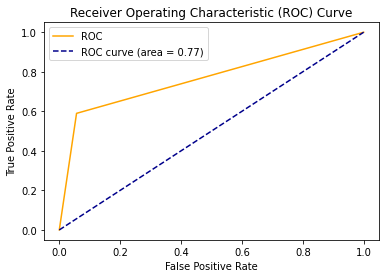

In [53]:
plt.plot(fpr_xgboost, tpr_xgboost, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='ROC curve (area = %0.2f)' % auc_xgboost)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Logistic Regression

In [54]:
log_reg = LogisticRegression(max_iter=300)
log_reg.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
accuracy_score(train_y, log_reg.predict(train_x))

0.8101238589913022

In [56]:
y_pred_log = log_reg.predict(test_x)

In [57]:
accuracy_score(test_y, y_pred_log)

0.8109486360285082

In [58]:
conf_mat = confusion_matrix(test_y, y_pred_log)
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]
Accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
Precision = true_positive/(true_positive+false_positive)
Recall = true_positive/(true_positive+false_negative)
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
auc = roc_auc_score(test_y, y_pred_log)
fpr_log, tpr_log, thresholds_log = roc_curve(test_y, y_pred_log)
print('Accuracy:: ', Accuracy)
print('Precision:: ', Precision)
print('Recall:: ', Recall)
print('F1 Score:: ', F1_Score)
print('AUC:: ', auc)

Accuracy::  0.8109486360285082
Precision::  0.9320193081255028
Recall::  0.838459868278208
F1 Score::  0.882767554387168
AUC::  0.6758380471984768


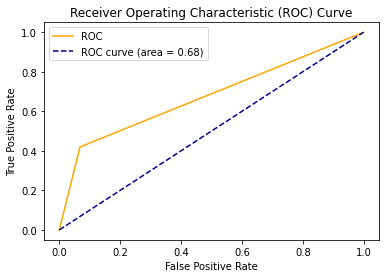

In [59]:
plt.plot(fpr_log, tpr_log, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Decision Tree Classifier

In [60]:
clf = DecisionTreeClassifier()
clf.fit(train_x, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [61]:
clf.score(train_x, train_y)

0.9998770630359284

In [62]:
y_pred_dtc = clf.predict(test_x)

In [63]:
clf.score(test_x, test_y)

0.8078151880068813

In [64]:
grid_param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,32,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'splitter' : ['best', 'random'] 
}

In [65]:
grid_search_decision = GridSearchCV(estimator = clf, param_grid = grid_param_dt, cv = 5, n_jobs = -1)

In [66]:
grid_search_decision.fit(train_x, train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [67]:
grid_search_decision.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'splitter': 'best'}

In [68]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=2, min_samples_split=9, splitter='random')
clf.fit(train_x, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=14, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

In [69]:
clf.score(test_x, test_y)

0.8492872941754731

In [70]:
y_pred_dt = clf.predict(test_x)
accuracy_score(test_y, y_pred_dt)

0.8492872941754731

In [71]:
conf_mat_dt = confusion_matrix(test_y, y_pred_dt)
true_positive_dt = conf_mat_dt[0][0]
false_positive_dt = conf_mat_dt[0][1]
false_negative_dt = conf_mat_dt[1][0]
true_negative_dt = conf_mat_dt[1][1]
Accuracy_dt = (true_positive_dt + true_negative_dt) / (true_positive_dt + false_positive_dt + false_negative_dt + true_negative_dt)
Precision_dt = true_positive_dt / (true_positive_dt + false_positive_dt)
Recall_dt = true_positive_dt / (true_positive_dt + false_negative_dt)
F1_Score_dt = 2 * (Recall_dt * Precision_dt) / (Recall_dt + Precision_dt)
auc_dt = roc_auc_score(test_y, y_pred_dt)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(test_y, y_pred_dt)
print('Accuracy:: ', Accuracy_dt)
print('Precision:: ', Precision_dt)
print('Recall:: ', Recall_dt)
print('F1 Score:: ', F1_Score_dt)
print('AUC:: ', auc_dt)

Accuracy::  0.8492872941754731
Precision::  0.9387771520514884
Recall::  0.8733627722475863
F1 Score::  0.9048893024698538
AUC::  0.7494197772737942


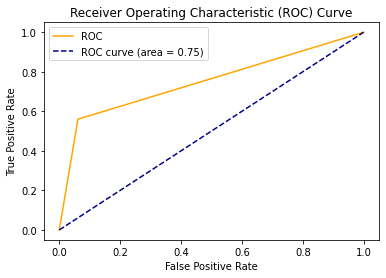

In [72]:
plt.plot(fpr_dt, tpr_dt, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='ROC curve (area = %0.2f)' % auc_dt)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### KNN Classifier

In [73]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, train_y)
knn.score(test_x, test_y)

0.7767879085770459

In [74]:
y_pred_knn = knn.predict(test_x)

In [75]:
print("The accuracy score is : ", accuracy_score(test_y, y_pred_knn))

The accuracy score is :  0.7767879085770459


In [76]:
param_grid_knn = {'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size' : [18, 20, 25, 27, 30, 32, 34],
              'n_neighbors' : [3, 5, 7, 9, 10, 11, 12, 13]
             }

In [103]:
gridsearch_knn = GridSearchCV(knn, param_grid_knn)

In [104]:
gridsearch_knn.fit(train_x, train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=18,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=13, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [18, 20, 25, 27, 30, 32, 34],
                         'n_neighbors': [3, 5, 7, 9, 10, 11, 12, 13]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [80]:
gridsearch_knn.best_params_

{'algorithm': 'ball_tree', 'leaf_size': 18, 'n_neighbors': 13}

In [81]:
knn = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size =18, n_neighbors =13)

In [83]:
knn.fit(train_x, train_y)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=18, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

In [84]:
knn.score(train_x, train_y)

0.8110151519808219

In [85]:
knn.score(test_x, test_y)

0.7970631604816908

In [86]:
y_pred_knn = knn.predict(test_x)
accuracy_score(test_y, y_pred_knn)

0.7970631604816908

In [87]:
conf_mat_knn = confusion_matrix(test_y, y_pred_knn)
true_positive_knn = conf_mat_knn[0][0]
false_positive_knn = conf_mat_knn[0][1]
false_negative_knn = conf_mat_knn[1][0]
true_negative_knn = conf_mat_knn[1][1]
Accuracy_knn = (true_positive_knn + true_negative_knn) / (true_positive_knn + false_positive_knn + false_negative_knn + true_negative_knn)
Precision_knn = true_positive_knn / (true_positive_knn + false_positive_knn)
Recall_knn = true_positive_knn / (true_positive_knn + false_negative_knn)
F1_Score_knn = 2 * (Recall_knn * Precision_knn) / (Recall_knn + Precision_knn)
auc_knn = roc_auc_score(test_y, y_pred_knn)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(test_y, y_pred_knn)
print('Accuracy:: ', Accuracy_knn)
print('Precision:: ', Precision_knn)
print('Recall:: ', Recall_knn)
print('F1 Score:: ', F1_Score_knn)
print('AUC:: ', auc_knn)

Accuracy::  0.7970631604816908
Precision::  0.9710378117457763
Recall::  0.8039698927596083
F1 Score::  0.8796414386182267
AUC::  0.6029136016607196


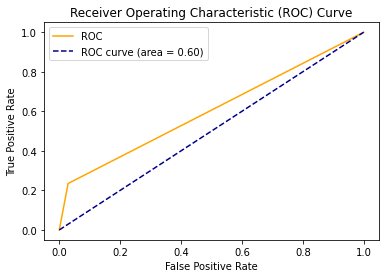

In [88]:
plt.plot(fpr_knn, tpr_knn, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='ROC curve (area = %0.2f)' % auc_knn)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Random Forest Classifier

In [89]:
rand_clf = RandomForestClassifier(random_state=6)

In [90]:
rand_clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)

In [91]:
rand_clf.score(test_x, test_y)

0.8489800933890391

In [92]:
grid_param_rdf = {
    "n_estimators" : [90,100,115],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf' : [1,2,3,4,5],
    'min_samples_split': [4,5,6,7,8],
    'max_features' : ['auto','log2']
}

In [105]:
grid_search_rdf = GridSearchCV(estimator=rand_clf, param_grid=grid_param_rdf, cv=5, n_jobs=-1)

In [106]:
grid_search_rdf.fit(train_x, train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=3,
                                              min_samples_split=7,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
  

In [95]:
grid_search_rdf.best_params_

{'criterion': 'entropy',
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 100}

In [96]:
rand_clf = RandomForestClassifier(criterion= 'entropy', max_features = 'auto', min_samples_leaf = 3, min_samples_split= 7, 
                                  n_estimators = 100)

In [97]:
rand_clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [98]:
rand_clf.score(test_x, test_y)

0.8585647579257802

In [99]:
y_pred_rdf = rand_clf.predict(test_x)
accuracy_score(test_y, y_pred_rdf)

0.8585647579257802

In [100]:
conf_mat_rdf = confusion_matrix(test_y, y_pred_rdf)
true_positive_rdf = conf_mat_rdf[0][0]
false_positive_rdf = conf_mat_rdf[0][1]
false_negative_rdf = conf_mat_rdf[1][0]
true_negative_rdf = conf_mat_rdf[1][1]
Accuracy_rdf = (true_positive_rdf + true_negative_rdf) / (true_positive_rdf + false_positive_rdf + false_negative_rdf + true_negative_rdf)
Precision_rdf = true_positive_rdf / (true_positive_rdf + false_positive_rdf)
Recall_rdf = true_positive_rdf / (true_positive_rdf + false_negative_rdf)
F1_Score_rdf = 2 * (Recall_rdf * Precision_rdf) / (Recall_rdf + Precision_rdf)
auc_rdf = roc_auc_score(test_y, y_pred_rdf)
fpr_rdf, tpr_rdf, thresholds_rdf = roc_curve(test_y, y_pred_rdf)
print('Accuracy:: ', Accuracy_rdf)
print('Precision:: ', Precision_rdf)
print('Recall:: ', Recall_rdf)
print('F1 Score:: ', F1_Score_rdf)
print('AUC:: ', auc_rdf)

Accuracy::  0.8585647579257802
Precision::  0.9483507642799678
Recall::  0.8765615704937537
F1 Score::  0.9110441301491614
AUC::  0.7583667497946901


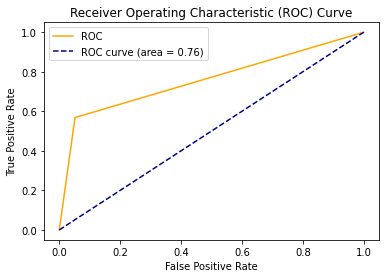

In [101]:
plt.plot(fpr_rdf, tpr_rdf, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='ROC curve (area = %0.2f)' % auc_rdf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Comparing scores of different classification models

In [102]:
print('Score of Logistic Regression::', F1_Score)
print('Score of Decision Tree::      ', F1_Score_dt)
print('Score of Random Forest::      ', F1_Score_rdf)
print('Score of K-Nearest Neighbors::', F1_Score_knn)
print('Score of XGBoost::            ', F1_Score_xgboost)

Score of Logistic Regression:: 0.882767554387168
Score of Decision Tree::       0.9048893024698538
Score of Random Forest::       0.9110441301491614
Score of K-Nearest Neighbors:: 0.8796414386182267
Score of XGBoost::             0.9112812342128784


After comparing the scores, we see that xgboost model is performing better as compared to others

Project Done By: Urvi Gadda

mailto: urvigada96@gmail.com